## Import modules

In [1]:
from common_dirs_fns import *
from propy_functions import *
import pandas as pd
import numpy as np
import regex
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Specify matplotlib formatting
%matplotlib inline
mpl.rcParams['svg.fonttype']='none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 7})

## Import tables

In [3]:
# Import quality-controlled versions of stats_table (experimental data) and bootstrap_summary (bootstrap data)
# These should have the same indices
stats_table = pd.read_csv(analysis_path+'stats_table_clean.csv', index_col=0, header=0, na_filter=False)

# Import human AMP peptide information scraped from APD3 along with clustering information
peptides_df = pd.read_excel(analysis_path+'human_AMP_properties.xlsx', index_col=0).reset_index()

# Import peptide features
peptide_features = pd.read_csv(analysis_path + 'peptide_features.tsv',
                               index_col = 0, sep='\t', na_filter=False)

## Plot fold changes for human AMP activators

In [4]:
# Create new table with just human AMP activators
hAMP_activators = stats_table[(stats_table.index.isin(peptides_df['Sequence']))
                              &(stats_table['Fold Change_Simple']>2)].sort_values('Fold Change_Simple')

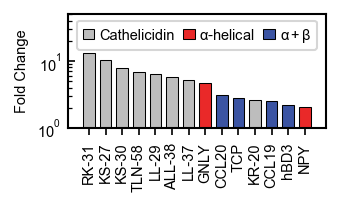

In [5]:
from matplotlib.patches import Patch

fig = plt.figure(figsize=(1.7, 1.), dpi=150)
ax = plt.subplot()

# Default color for peptides is grey
hAMP_colors = pd.Series(['#bdbdbd']*len(hAMP_activators), index=hAMP_activators.index)

# # Cathelicidin-related peptides are red
# hAMP_colors = hAMP_colors.mask(hAMP_activators['Cluster']==cathelicidin_cluster, 'r')

# Activators with alpha-helix structure are red
hAMP_colors = hAMP_colors.mask(peptides_df.set_index('Sequence').loc[hAMP_activators.index,'SimpleName'].isin(
                        ['Human granulysin', 'Neuropeptide Y']), '#E92929')

# Activators with a combined alpha-helix/beta-sheet structure are blue
hAMP_colors = hAMP_colors.mask(peptides_df.set_index('Sequence').loc[hAMP_activators.index,'SimpleName'].isin(
                        ['TCP','CCL19','CCL20','Human beta defensin 3']),'#3B54A3')

# Set additional plotting parameters
bar_width = 0.7
border_pad = bar_width/2+(1-bar_width)*3

# Assign bottom of plot to be fold change = 1
left = 1

# Plot bar plot of fold changes

bar_plot = plt.bar(np.arange(len(hAMP_activators))[::-1],
                     hAMP_activators['Fold Change_Simple'] - left, # height of bars
                     error_kw={'capthick':0.5,'elinewidth':0.5,'capsize':2},
                     color=hAMP_colors.values,
                     edgecolor='k',
                     linewidth=0.5,
                     width=bar_width,
                     bottom=left)

# Assign y tick labels
xtick_labels = peptides_df.set_index('Sequence').loc[hAMP_activators.index,'SimpleName'].apply(
                        lambda x: capitalize_first(regex.split('[hH]uman ',x)[-1]))[::-1]

abbreviated_names = {'Granulysin': 'GNLY',
                        'Beta defensin 3': 'hBD3',
                        'Neuropeptide Y': 'NPY'}

xtick_labels = xtick_labels.apply(lambda x: abbreviated_names[x] if x in abbreviated_names.keys() else x)


plt.xticks(np.arange(len(hAMP_activators)), xtick_labels.values, rotation='vertical')

# Set y axis limits and readjust figure height to be consistent across plots
plt.xlim([-border_pad, len(hAMP_activators)-1+border_pad])
fig.set_size_inches((plt.xlim()[1]-plt.xlim()[0])/7., 1.)

# Set x axis parameters
plt.yscale('log')
plt.ylabel('Fold Change')
plt.ylim([1., 50.])
plt.tick_params(which='both', axis='y', direction='in')

locmaj = mpl.ticker.LogLocator(base=10., numticks=10)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
                                          numticks=10)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_major_locator(locmaj)

plt.legend(handles=[Patch(facecolor=hAMP_colors.loc[peptides_df.set_index('SimpleName').loc['LL-37', 'Sequence']],
                  edgecolor='k', linewidth=0.5,
                  label='Cathelicidin'),
            Patch(facecolor=hAMP_colors.loc[peptides_df.set_index('SimpleName').loc['Human granulysin', 'Sequence']],
                  edgecolor='k', linewidth=0.5,
                  label=r'$\alpha$-helical'),
            Patch(facecolor=hAMP_colors.loc[peptides_df.set_index('SimpleName').loc['CCL20', 'Sequence']],
                  edgecolor='k', linewidth=0.5,
                  label=r'$\alpha+\beta$')],
           handlelength=0.8, ncol=3,
           columnspacing=0.6, handletextpad=0.3,
           bbox_to_anchor=[0.5, 1.01], loc='upper center')

plt.savefig(figures_path+'activator_fc_vertical_bar.png', bbox_inches='tight')
plt.savefig(figures_path+'activator_fc_vertical_bar.svg', bbox_inches='tight')

## Plot fold changes for cathelicidin-like peptides (TLN-58 derivatives)

In [6]:
# Save sequence for longest cathelicidin in human AMP library (TLN-58)
tln58_seq = peptides_df.loc[peptides_df['SimpleName']=='TLN-58','Sequence'].values[0]

In [7]:
# Identify all peptides with sequencing data that constitute a subset of the TLN-58 sequence and
# save peptides to a dictionary
in_tln58 = {}

for seq in stats_table.index:
    # Ignore sequences that are too long or the non-alphanumeric '*',
    # which represents no peptide.
    if len(seq) > len(tln58_seq) or seq == '*':
        continue
    regex_result = regex.search(seq, tln58_seq)
    if regex_result is not None:
        in_tln58[seq] = regex_result.span()

In [8]:
# Create a dataframe based on the TLN-58 subset dictionary
in_tln58_df = pd.DataFrame.from_dict(in_tln58, orient='index', columns=['Start','End'])
in_tln58_df = in_tln58_df.sort_values(['Start','End'], ascending=[True, False])
in_tln58_df['Length'] = in_tln58_df['End'] - in_tln58_df['Start']

# Add fold change information about the peptides to the TLN-58 dataframe
in_tln58_df['Fold Change'] = in_tln58_df.index.map(lambda x: stats_table.loc[x, 'Fold Change_Simple'])

# Eliminate short peptides (fewer than 3 amino acids in length)
in_tln58_df = in_tln58_df[in_tln58_df['Length'] >= 3]

In [9]:
# Create a new normalization class for generating lognormal colorbars.
# This class creates a colorbar with equal spacing (in log space) on
# either side of a user-defined midpoint that is clipped based on
# vmin and vmax.

class MidPointLogNormFair(mpl.colors.LogNorm):
    '''
    Based on two answers from StackOverflow:
    MidPointLogNorm: https://stackoverflow.com/a/48632237
    MidPointNormalizeFair: https://stackoverflow.com/a/55667609
    '''
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mpl.colors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
        
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        
        vlargest = max(abs(np.log(self.vmax) - np.log(self.midpoint)),
                       abs(np.log(self.vmin) - np.log(self.midpoint)))
        
        x, y = [np.log(self.midpoint) - vlargest,
                np.log(self.midpoint),
                np.log(self.midpoint) + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

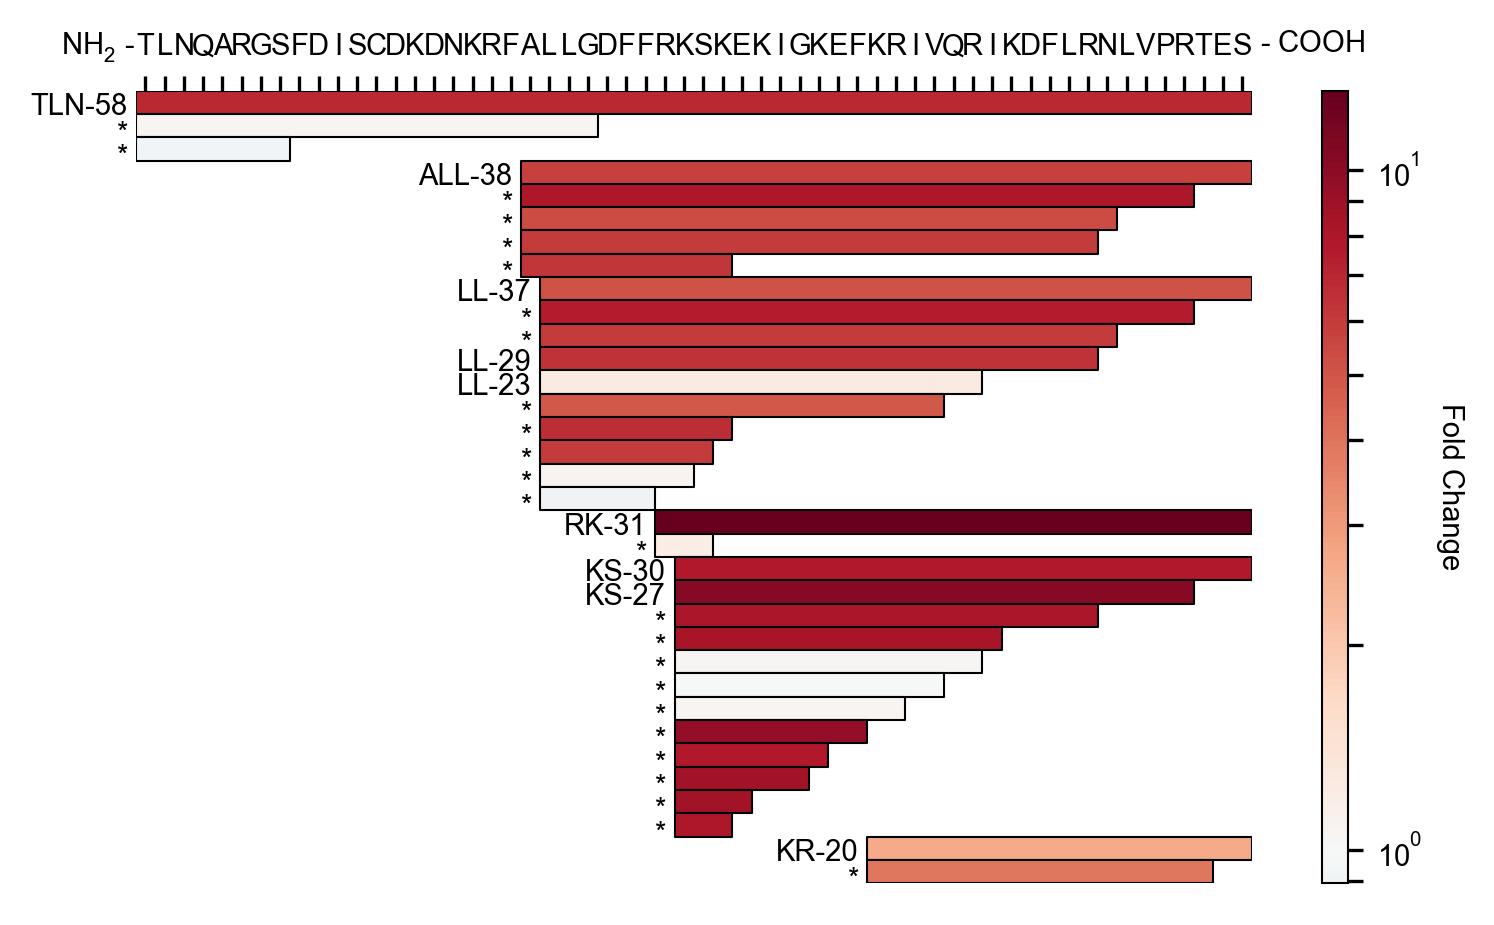

In [10]:
# Create a new figure
fig = plt.figure(figsize=(6., 3.5), dpi=300)
ax = plt.subplot(frameon=False)

text_size = 7

# Create a PatchCollection of horizontal bars where the length and location of the
# bar represents the span of TLN-58 occupied by a given peptide sequence and the
# color represents the fold change in activation observed for that peptide
rects = []
for i,seq in enumerate(in_tln58_df.index):
    rects.append(Rectangle((in_tln58_df.loc[seq,'Start'], len(in_tln58_df)-1-i),
                           len(seq), 1))
pc = mpl.collections.PatchCollection(rects)
vmin = in_tln58_df['Fold Change'].min()
vmax = in_tln58_df['Fold Change'].max()
norm = MidPointLogNormFair(vmin=vmin/1., vmax=vmax*1., midpoint=1.)
pc.set(array=in_tln58_df['Fold Change'].values, cmap='RdBu_r',
       norm=norm, edgecolor='k', lw=0.5)
ax.add_collection(pc)


# Add a colorbar based on the colormap settings for the PatchCollection (above)
cbar = plt.colorbar(pc,
                    ticks=mpl.ticker.LogLocator(base=10,numticks=10,subs=np.arange(0.1, 1.0, 0.1)),
                    aspect=30)
cbar.set_label('Fold Change',rotation=-90,labelpad=10)
cbar.outline.set_edgecolor('k')
cbar.outline.set_linewidth(0.5)


# Set axis limits and ticks
ax.xaxis.set_ticks_position('top')
plt.xticks(list(np.arange(len(tln58_seq))+0.5), labels=list(tln58_seq), size=text_size)
ax.set_xlim([0,len(tln58_seq)])
ax.set_ylim([0,len(in_tln58_df)])
ax.set_yticks([])


# Label any human AMPs with their name and label other peptides with an asterisk
for i, seq in enumerate(in_tln58_df.index):
    try:
        simpleName = peptides_df.set_index('Sequence').loc[seq,'SimpleName']
        # Remove 'Human' or 'human' from the beginning of simpleName for consistency
        simpleName = capitalize_first(regex.split('[hH]uman ',simpleName)[-1])
        vert_offset = 0.3
    except KeyError:
        simpleName = '*'
        vert_offset = 0.1

    ax.text(in_tln58_df.loc[seq,'Start']-0.45, len(in_tln58_df)-1-i+vert_offset,simpleName,
            horizontalalignment='right',verticalalignment='center',size=text_size)


# Add NH2 and COOH labels to either side of the TLN-58 sequence
ax.text(0,len(in_tln58_df)+2.6,'$NH_{2}$ - ',size=text_size, 
        horizontalalignment='right', verticalalignment='top')

ax.text(len(tln58_seq),len(in_tln58_df)+2.6,' - $COOH$',size=text_size,
        horizontalalignment='left', verticalalignment='top')

# Save to file
plt.savefig(figures_path+'cathelicidin_bars.png', bbox_inches='tight', dpi=600)
plt.savefig(figures_path+'cathelicidin_bars.svg', bbox_inches='tight', dpi=600)

## Plot property correlations for human AMPs based on cluster

In [11]:
# Generate lists of different types of activating AMPs

# List of human cathelicidins
cathelicidin_cluster = peptides_df.loc[peptides_df['SimpleName']=='LL-37', 'Cluster'].values[0]
human_cathelicidins = peptides_df[peptides_df['Cluster']==cathelicidin_cluster]['Sequence'].values

# List of human cathelicidin activators (fold change >= 2)
cathelicidin_activators = hAMP_activators.reindex(human_cathelicidins).dropna().index

# List of activators with alpha-helical secondary structure
alpha_activators = peptides_df.set_index('SimpleName').loc[
        ['Human granulysin', 'Neuropeptide Y'], 'Sequence'].values

# List of activators with combined alpha-beta structure
alpha_beta_activators = peptides_df.set_index('SimpleName').loc[
        ['CCL19', 'CCL20', 'Human beta defensin 3', 'TCP'], 'Sequence'].values

# List of peptides that are not activators and not human cathelicidins
non_activators = stats_table.index[(~stats_table.index.isin(np.concatenate([human_cathelicidins,
                                                         alpha_activators,
                                                         alpha_beta_activators])))
                                  &(~(stats_table.index=='*'))]


In [12]:
# Create a new dataframe for just peptides (remove no peptide '*' control)
stats_table1 = stats_table[stats_table.index!='*']

# Add basic peptide properties to stats_table1 for ease of plotting
for prop in ['Charge', 'GRAVY', 'Length']:
    # Copy properties from peptide_features for all peptides analyzed using propy
    stats_table1[prop] = stats_table1.index.map(lambda x: peptide_features.loc[x, prop]
                                                   if x in peptide_features.index else None)
    
    # Copy properties from peptides_df for all human peptides (see hAMP_properties notebook)
    stats_table1[prop] = stats_table1[prop].mask(stats_table1[prop].isna(),
                           list(stats_table1.index.map(lambda x:
                                        peptides_df.set_index('Sequence').loc[x, prop]
                                        if x in peptides_df['Sequence'].values else None)))
    
# Add cluster information to stats_table1
stats_table1['Cluster'] = stats_table1.index.map(lambda x: peptides_df.set_index('Sequence').loc[x, 'Cluster']
                                                    if x in peptides_df['Sequence'].values else None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [13]:
# Functions to calculate 25th and 75th percentiles
def pct_25(a):
    return np.percentile(a, 25)

def pct_75(a):
    return np.percentile(a, 75)

In [14]:
# Set up plotting formatting

plot_properties = {'cathelicidins': [
                                            human_cathelicidins, # sequences
                                            5., # marker size
                                            1., # alpha
                                            '#bdbdbd', # color
                                            0.25, # marker edge width
                                            1, # zorder
                                    ],
                   'alpha_activators': [
                                            alpha_activators,
                                            5.,
                                            1.,
                                            '#E92929',
                                            0.25,
                                            1
                                       ],
                   'alpha_beta_activators': [
                                            alpha_beta_activators,
                                            5.,
                                            1.,
                                            '#3B54A3',
                                            0.25,
                                            1
                                            ],
                   'non_activators': [
                                            non_activators,
                                            5.,
                                            0.3,
                                            'k',
                                            0.,
                                            -1
                   ]}


metrics = ['Charge', 'GRAVY'] #, 'Length']
metric_labels = metrics

metric_ticks = {'Charge': [[0, 10, 20],
                           mpl.ticker.MultipleLocator(5.),
                           [-8, 23]],
                'GRAVY': [[-2, 0],
                          mpl.ticker.MultipleLocator(1.),
                          [-3, 1]],
                'Length': [[0, 50, 100],
                           mpl.ticker.MultipleLocator(10.),
                           [-10, 110]]
                }

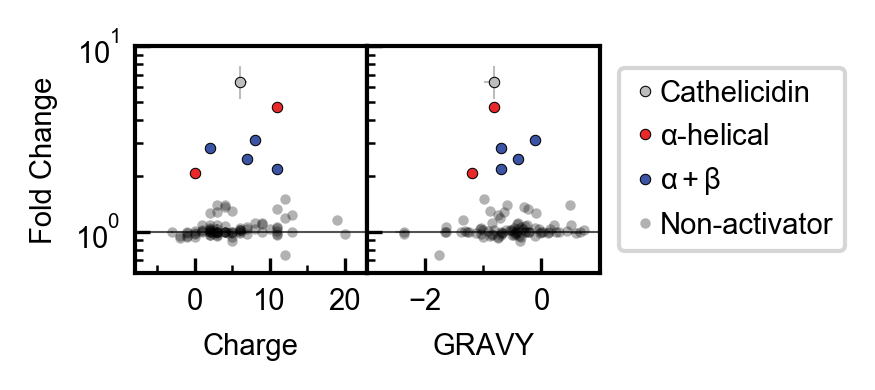

In [15]:
# Group peptide features + fold change by cluster
pt = pd.pivot_table(stats_table1.loc[stats_table1.index.isin(peptides_df['Sequence'])],
                    index = 'Cluster',
                    values = metrics + ['Fold Change_Simple'],
                    aggfunc = [np.median, pct_25, pct_75, 'count'])

# Create a figure
fig = plt.figure(figsize=(len(metrics), 1.), dpi=300)
gs = mpl.gridspec.GridSpec(1, len(metrics), wspace=0., hspace=0.)

handles = {}

# Iterate over metrics
for i,metric in enumerate(metrics):
    
    # Set up axis for scatterplot
    ax = plt.subplot(gs[0, i])
    
    # Iterate over groups of AMPs to plot
    for group in plot_properties.keys():
        
        # Get plotting information from plot_properties
        seqs = plot_properties[group][0]
        markersize = plot_properties[group][1]
        alpha = plot_properties[group][2]
        color = plot_properties[group][3]
        markeredgewidth = plot_properties[group][4]
        zorder = plot_properties[group][5]
        
        # Extract cluster information for sequences to plot
        clusters = stats_table1.loc[seqs, 'Cluster'].unique()
        
        # Plot data with errorbars based on median and 25th/75th percentiles
        handles[group] = ax.errorbar(pt.reindex(clusters)[('median', metric)],
                                     pt.reindex(clusters)[('median', 'Fold Change_Simple')],
                                     
                                 yerr=[pt.reindex(clusters)[('median', 'Fold Change_Simple')]
                                       -pt.reindex(clusters)[('pct_25', 'Fold Change_Simple')],
                                       pt.reindex(clusters)[('pct_75', 'Fold Change_Simple')]
                                       -pt.reindex(clusters)[('median', 'Fold Change_Simple')]],
                                     
                                 xerr=[pt.reindex(clusters)[('median', metric)]
                                       -pt.reindex(clusters)[('pct_25', metric)],
                                       pt.reindex(clusters)[('pct_75', metric)]
                                       -pt.reindex(clusters)[('median', metric)]],
                                     
                                 linestyle='',
                                 marker='.',
                                 markersize=markersize,
                                 alpha=alpha,
                                 color=color,
                                 linewidth=0.5,
                                 markeredgewidth=markeredgewidth,
                                 markeredgecolor='k',
                                 zorder=zorder)
    
    # Plot fold change = 1 line
    ax.axhline(1., color='#525252', zorder=-2, linewidth=0.5)
    
    
    # Set x and y axis parameters
    ax.set_yscale('log')
    ax.set_ylim([0.6, 10])
    ax.set_xlim(metric_ticks[metric][2])
    
    plt.tick_params(which='both', axis='both', direction='in')
    ax.set_xticks(metric_ticks[metric][0])
    ax.xaxis.set_minor_locator(metric_ticks[metric][1])
    
    if i == 0 or i == 4:
        ax.set_ylabel('Fold Change')
    else:
        ax.set_yticklabels([])
    
    # Add a legend
    if i == len(metrics)-1:
        plt.legend(handles=[handles[g][0] for g in ['cathelicidins',
                                                 'alpha_activators',
                                                 'alpha_beta_activators',
                                                 'non_activators']],
                  labels=['Cathelicidin', r'$\alpha$-helical', r'$\alpha+\beta$'+'\t', 'Non-activator'],
                  markerscale=1.,
                  ncol=1, handletextpad=0.01, columnspacing=0.5, handlelength=1.,
                  loc='center left', bbox_to_anchor=[1.02, 0.5])
    
    ax.set_xlabel(metric_labels[i])

# Save figure
plt.savefig(figures_path+'property_corr_hamps_clustered.png',dpi=600,bbox_inches='tight')
plt.savefig(figures_path+'property_corr_hamps_clustered.svg',dpi=300,bbox_inches='tight')